In [29]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl


import sys
sys.path.append('../Utilities/')

from tqdm.notebook import tqdm

import importlib
import data_utils
importlib.reload(data_utils)

## Import MDS from sklearn
from sklearn.manifold import MDS
from sklearn.metrics import accuracy_score, f1_score
mds = MDS(n_components=1, random_state=0, normalized_stress='auto')

### Building the Model

In [30]:
class SqueezeExciteBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SqueezeExciteBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction_ratio)
        self.fc2 = nn.Linear(in_channels // reduction_ratio, in_channels)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x_se = self.avg_pool(x)
        x_se = torch.flatten(x_se, 1)
        x_se = self.fc1(x_se)
        x_se = self.relu(x_se)
        x_se = self.fc2(x_se)
        x_se = self.sigmoid(x_se)
        x_se = x_se.unsqueeze(2)
        return x * x_se

In [31]:
class UNet1D_sne(nn.Module):
    def __init__(self, in_channels, out_channels, depth=2, num_layers=2):
        super(UNet1D_sne, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_layers = num_layers
        self.depth = depth
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.num_start_filters = 32

        self._create_unet(self.in_channels, self.num_start_filters)

        self.encoder_output_shape = int(np.floor(300/(2**depth)))
        self.encoder_feature_maps = int(self.num_start_filters * 2 ** (self.depth - 1))

        self.bottleneck = nn.Sequential(
            nn.Conv1d(self.encoder_feature_maps, 2 * self.encoder_feature_maps, kernel_size=1, padding=0),
            nn.ReLU()
        )

        self.logits = nn.Conv1d(self.num_start_filters, self.out_channels, 1, 1)

    def _create_encoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2),
            nn.ReLU(),
            SqueezeExciteBlock(out_channels)
        )

    def _create_decoder_block(self, in_channels, out_channels):
        return nn.ModuleList(
            [nn.ConvTranspose1d(in_channels, in_channels//2, kernel_size=2, stride=2),
            nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2),
            nn.ReLU(),
            SqueezeExciteBlock(out_channels)])

    def _create_unet(self, in_channels, out_channels):
        for _ in range(self.depth):
            self.encoder.append(self._create_encoder_block(in_channels, out_channels))
            in_channels, out_channels = out_channels, out_channels*2

        out_channels = in_channels
        in_channels = in_channels * 2
        for _ in range(self.depth):
            self.decoder.append(self._create_decoder_block(in_channels, out_channels))
            in_channels, out_channels = out_channels, out_channels//2

    def forward(self, x):
        encoded = []
        for enc in self.encoder:
            x = enc(x)
            encoded.append(x)
            x = nn.MaxPool1d(kernel_size=2, stride=2)(x)
            
        x = self.bottleneck(x)  # Bottleneck layer
        # x = torch.reshape(x, (-1, self.encoder_feature_maps*2, self.encoder_output_shape))


        for dec in self.decoder:
            ## Adding input with encoder concatenation
            enc_output = encoded.pop()
            x = dec[0](x)
            ## Pad the decoder output to match the encoder output
            diff = enc_output.shape[2] - x.shape[2]
            x = F.pad(x, (diff // 2, diff - diff // 2))
            x = torch.cat((enc_output, x), dim=1)
            x = dec[1](x)
            x = dec[2](x)
        ## Add softmax to logits
        # x = self.softmax(x)

        return self.logits(x)

input_channels = 6 
output_channels = 1
depth = 3
num_layers = 2

model = UNet1D_sne(input_channels, output_channels, depth, num_layers)
# print(model)

In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [33]:
# Generate synthetic data
num_superpixels = 300
num_features = 6
synthetic_data = np.random.rand(num_superpixels, num_features)
synthetic_data = torch.tensor(synthetic_data, dtype=torch.float32)

#Reshape
synthetic_data = synthetic_data.unsqueeze(0).transpose(1, 2)

# Pass the synthetic data through the U-Net model
with torch.no_grad():
    output = model(synthetic_data)

print("Input shape:", synthetic_data.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([1, 6, 300])
Output shape: torch.Size([1, 1, 300])


### Creating LightningModule 

In [34]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = dice_loss + BCE
        
        return Dice_BCE

In [35]:
class CloudSegmentationModel(pl.LightningModule):
    def __init__(self, depth=2):
        super(CloudSegmentationModel, self).__init__()
        self.unet = UNet1D_sne(in_channels=6, out_channels=1, depth=depth)
        
    def forward(self, x):
        return nn.Sigmoid()(self.unet(x))

    def accuracy_score(self, y_true, y_pred):
        y_true = y_true.cpu().detach().numpy()
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = np.where(y_pred > 0.5, 1, 0)
        return accuracy_score(y_true, y_pred)

    def training_step(self, batch, batch_idx):
        superpixel, label = batch
        output = self(superpixel)
        loss = nn.BCELoss()(output, label)

        # Calculate accuracy
        predicted = torch.round(output)
        correct = (predicted == label).sum().item()
        total = label.size(0) * label.size(1) * label.size(2)
        accuracy = correct / total

        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_accuracy', accuracy, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        superpixel, label = batch
        output = self(superpixel)
        loss = nn.BCELoss()(output, label)

        # Calculate accuracy
        predicted = torch.round(output)
        correct = (predicted == label).sum().item()
        total = label.size(0) * label.size(1) * label.size(2)
        accuracy = correct / total

        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_accuracy', accuracy, on_step=False, on_epoch=True)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [36]:
model = CloudSegmentationModel(depth=2)
print("Parameters: ",count_parameters(model))

with torch.no_grad():
    output = model(synthetic_data)

print("Input shape:", synthetic_data.shape)
print("Output shape:", output.shape)

Parameters:  93005
Input shape: torch.Size([1, 6, 300])
Output shape: torch.Size([1, 1, 300])


### Creating Dataset

In [37]:
patches,mask = data_utils.get_patch(path_to_folders_images = "../Dataset/Natural_False_Color/", path_to_folders_labels = "../Dataset/Entire_scene_gts/")

In [71]:
X = np.load('../Dataset/X_pca.npy')
y = np.load('../Dataset/Y_pca.npy')
raw = np.load('../Dataset/raw.npy')
slic_map = np.load('../Dataset/slic_map_pca.npy')
original_ordering = np.load('../Dataset/original_ordering_pca.npy', allow_pickle=True)

In [100]:
np.save('patch.npy', patches[100:110])
np.save('mask.npy', mask[100:110])

In [72]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x_item = torch.tensor(self.X[idx], dtype=torch.float32).T
        y_item = torch.tensor(self.y[idx], dtype=torch.float32).T
        return x_item, y_item

def create_dataloader(X, y, batch_size=32, shuffle=True):
    dataset = CustomDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [73]:
## Divide X and Y into train and test sets
np.random.seed(42)
test_index = np.random.choice(range(len(X)), size=200, replace=False)
train_index = [i for i in range(len(X)) if i not in test_index]

X_train = X[train_index]
X_test = X[test_index]
y_train = y[train_index]
y_test = y[test_index]

In [74]:
train_loader = create_dataloader(X_train,y_train,batch_size=64,shuffle=True)
test_loader = create_dataloader(X_test,y_test,batch_size=64,shuffle=True)

## Training with PL

In [58]:
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger

In [59]:
# Initialize the model and trainer
segmentationModel = CloudSegmentationModel(depth=2)

In [60]:
logger = TensorBoardLogger('lightning_logs/', name='sgd_tagger_sne_500')

In [61]:
checkpoint_callback = ModelCheckpoint(
    dirpath = './sne500_model_checkpt/',
    filename = 'best-checkpoint',
    save_top_k=1,
    verbose = True,
    monitor='val_loss',
    mode='min'
)

In [62]:
trainer = Trainer(
    logger = logger,
    accelerator="auto",
    max_epochs=1000,
    callbacks=[EarlyStopping(monitor='val_loss', patience=20), checkpoint_callback]
)

# Train the model using the trainer
trainer.fit(segmentationModel, train_loader, test_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/sgd_tagger_sne_500
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | unet | UNet1D_sne | 93.0 K
------------------------------------
93.0 K    Trainable params
0         Non-trainable params
93.0 K    Total params
0.372     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 24/24 [00:00<00:00, 35.58it/s, loss=0.675, v_num=0]

Epoch 0, global step 20: 'val_loss' reached 0.65812 (best 0.65812), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 1: 100%|██████████| 24/24 [00:00<00:00, 57.97it/s, loss=0.631, v_num=0]

Epoch 1, global step 40: 'val_loss' reached 0.59593 (best 0.59593), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 2: 100%|██████████| 24/24 [00:00<00:00, 56.08it/s, loss=0.581, v_num=0]

Epoch 2, global step 60: 'val_loss' reached 0.56244 (best 0.56244), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 3: 100%|██████████| 24/24 [00:00<00:00, 61.14it/s, loss=0.57, v_num=0] 

Epoch 3, global step 80: 'val_loss' reached 0.55262 (best 0.55262), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 4: 100%|██████████| 24/24 [00:00<00:00, 57.35it/s, loss=0.558, v_num=0]

Epoch 4, global step 100: 'val_loss' reached 0.53730 (best 0.53730), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 5: 100%|██████████| 24/24 [00:00<00:00, 57.55it/s, loss=0.536, v_num=0]

Epoch 5, global step 120: 'val_loss' reached 0.52442 (best 0.52442), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 6: 100%|██████████| 24/24 [00:00<00:00, 60.99it/s, loss=0.519, v_num=0]

Epoch 6, global step 140: 'val_loss' reached 0.49987 (best 0.49987), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 7: 100%|██████████| 24/24 [00:00<00:00, 58.82it/s, loss=0.503, v_num=0]

Epoch 7, global step 160: 'val_loss' reached 0.48210 (best 0.48210), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 8: 100%|██████████| 24/24 [00:00<00:00, 58.97it/s, loss=0.484, v_num=0]

Epoch 8, global step 180: 'val_loss' reached 0.45803 (best 0.45803), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 9: 100%|██████████| 24/24 [00:00<00:00, 56.47it/s, loss=0.461, v_num=0]

Epoch 9, global step 200: 'val_loss' reached 0.43577 (best 0.43577), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 10: 100%|██████████| 24/24 [00:00<00:00, 58.89it/s, loss=0.445, v_num=0]

Epoch 10, global step 220: 'val_loss' reached 0.42573 (best 0.42573), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 11: 100%|██████████| 24/24 [00:00<00:00, 57.40it/s, loss=0.421, v_num=0]

Epoch 11, global step 240: 'val_loss' reached 0.41641 (best 0.41641), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 12: 100%|██████████| 24/24 [00:00<00:00, 61.10it/s, loss=0.421, v_num=0]

Epoch 12, global step 260: 'val_loss' was not in top 1


Epoch 13: 100%|██████████| 24/24 [00:00<00:00, 57.55it/s, loss=0.406, v_num=0]

Epoch 13, global step 280: 'val_loss' reached 0.40665 (best 0.40665), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 14: 100%|██████████| 24/24 [00:00<00:00, 59.11it/s, loss=0.405, v_num=0]

Epoch 14, global step 300: 'val_loss' reached 0.38060 (best 0.38060), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 15: 100%|██████████| 24/24 [00:00<00:00, 57.77it/s, loss=0.381, v_num=0]

Epoch 15, global step 320: 'val_loss' reached 0.37120 (best 0.37120), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 16: 100%|██████████| 24/24 [00:00<00:00, 55.56it/s, loss=0.366, v_num=0]

Epoch 16, global step 340: 'val_loss' reached 0.36178 (best 0.36178), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 17: 100%|██████████| 24/24 [00:00<00:00, 53.81it/s, loss=0.354, v_num=0]

Epoch 17, global step 360: 'val_loss' reached 0.35504 (best 0.35504), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 18: 100%|██████████| 24/24 [00:00<00:00, 57.83it/s, loss=0.346, v_num=0]

Epoch 18, global step 380: 'val_loss' reached 0.35436 (best 0.35436), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 19: 100%|██████████| 24/24 [00:00<00:00, 57.97it/s, loss=0.343, v_num=0]

Epoch 19, global step 400: 'val_loss' reached 0.34602 (best 0.34602), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 20: 100%|██████████| 24/24 [00:00<00:00, 56.21it/s, loss=0.341, v_num=0]

Epoch 20, global step 420: 'val_loss' reached 0.33278 (best 0.33278), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 21: 100%|██████████| 24/24 [00:00<00:00, 59.03it/s, loss=0.328, v_num=0]

Epoch 21, global step 440: 'val_loss' reached 0.33040 (best 0.33040), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 22: 100%|██████████| 24/24 [00:00<00:00, 57.47it/s, loss=0.32, v_num=0] 

Epoch 22, global step 460: 'val_loss' was not in top 1


Epoch 23: 100%|██████████| 24/24 [00:00<00:00, 59.15it/s, loss=0.316, v_num=0]

Epoch 23, global step 480: 'val_loss' reached 0.32349 (best 0.32349), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 24: 100%|██████████| 24/24 [00:00<00:00, 56.46it/s, loss=0.322, v_num=0]

Epoch 24, global step 500: 'val_loss' reached 0.31874 (best 0.31874), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 25: 100%|██████████| 24/24 [00:00<00:00, 57.90it/s, loss=0.316, v_num=0]

Epoch 25, global step 520: 'val_loss' was not in top 1


Epoch 26: 100%|██████████| 24/24 [00:00<00:00, 54.76it/s, loss=0.316, v_num=0]

Epoch 26, global step 540: 'val_loss' reached 0.31246 (best 0.31246), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 27: 100%|██████████| 24/24 [00:00<00:00, 56.54it/s, loss=0.315, v_num=0]

Epoch 27, global step 560: 'val_loss' reached 0.30852 (best 0.30852), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 28: 100%|██████████| 24/24 [00:00<00:00, 53.22it/s, loss=0.299, v_num=0]

Epoch 28, global step 580: 'val_loss' reached 0.30579 (best 0.30579), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 29: 100%|██████████| 24/24 [00:00<00:00, 57.83it/s, loss=0.297, v_num=0]

Epoch 29, global step 600: 'val_loss' was not in top 1


Epoch 30: 100%|██████████| 24/24 [00:00<00:00, 53.57it/s, loss=0.297, v_num=0]

Epoch 30, global step 620: 'val_loss' was not in top 1


Epoch 31: 100%|██████████| 24/24 [00:00<00:00, 54.92it/s, loss=0.321, v_num=0]

Epoch 31, global step 640: 'val_loss' was not in top 1


Epoch 32: 100%|██████████| 24/24 [00:00<00:00, 53.93it/s, loss=0.296, v_num=0]

Epoch 32, global step 660: 'val_loss' reached 0.30505 (best 0.30505), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 33: 100%|██████████| 24/24 [00:00<00:00, 55.74it/s, loss=0.293, v_num=0]

Epoch 33, global step 680: 'val_loss' was not in top 1


Epoch 34: 100%|██████████| 24/24 [00:00<00:00, 57.69it/s, loss=0.301, v_num=0]

Epoch 34, global step 700: 'val_loss' reached 0.29921 (best 0.29921), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 35: 100%|██████████| 24/24 [00:00<00:00, 61.38it/s, loss=0.299, v_num=0]

Epoch 35, global step 720: 'val_loss' was not in top 1


Epoch 36: 100%|██████████| 24/24 [00:00<00:00, 55.76it/s, loss=0.294, v_num=0]

Epoch 36, global step 740: 'val_loss' reached 0.29586 (best 0.29586), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 37: 100%|██████████| 24/24 [00:00<00:00, 58.25it/s, loss=0.288, v_num=0]

Epoch 37, global step 760: 'val_loss' was not in top 1


Epoch 38: 100%|██████████| 24/24 [00:00<00:00, 55.05it/s, loss=0.286, v_num=0]

Epoch 38, global step 780: 'val_loss' was not in top 1


Epoch 39: 100%|██████████| 24/24 [00:00<00:00, 53.75it/s, loss=0.281, v_num=0]

Epoch 39, global step 800: 'val_loss' was not in top 1


Epoch 40: 100%|██████████| 24/24 [00:00<00:00, 56.87it/s, loss=0.283, v_num=0]

Epoch 40, global step 820: 'val_loss' was not in top 1


Epoch 41: 100%|██████████| 24/24 [00:00<00:00, 54.80it/s, loss=0.281, v_num=0]

Epoch 41, global step 840: 'val_loss' reached 0.29135 (best 0.29135), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 42: 100%|██████████| 24/24 [00:00<00:00, 60.07it/s, loss=0.281, v_num=0]

Epoch 42, global step 860: 'val_loss' was not in top 1


Epoch 43: 100%|██████████| 24/24 [00:00<00:00, 54.81it/s, loss=0.283, v_num=0]

Epoch 43, global step 880: 'val_loss' was not in top 1


Epoch 44: 100%|██████████| 24/24 [00:00<00:00, 56.07it/s, loss=0.278, v_num=0]

Epoch 44, global step 900: 'val_loss' was not in top 1


Epoch 45: 100%|██████████| 24/24 [00:00<00:00, 57.40it/s, loss=0.276, v_num=0]

Epoch 45, global step 920: 'val_loss' reached 0.28970 (best 0.28970), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 46: 100%|██████████| 24/24 [00:00<00:00, 53.32it/s, loss=0.288, v_num=0]

Epoch 46, global step 940: 'val_loss' was not in top 1


Epoch 47: 100%|██████████| 24/24 [00:00<00:00, 57.69it/s, loss=0.283, v_num=0]

Epoch 47, global step 960: 'val_loss' reached 0.28676 (best 0.28676), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 48: 100%|██████████| 24/24 [00:00<00:00, 50.64it/s, loss=0.274, v_num=0]

Epoch 48, global step 980: 'val_loss' reached 0.28565 (best 0.28565), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 49: 100%|██████████| 24/24 [00:00<00:00, 56.03it/s, loss=0.284, v_num=0]

Epoch 49, global step 1000: 'val_loss' was not in top 1


Epoch 50: 100%|██████████| 24/24 [00:00<00:00, 56.14it/s, loss=0.278, v_num=0]

Epoch 50, global step 1020: 'val_loss' was not in top 1


Epoch 51: 100%|██████████| 24/24 [00:00<00:00, 56.07it/s, loss=0.277, v_num=0]

Epoch 51, global step 1040: 'val_loss' was not in top 1


Epoch 52: 100%|██████████| 24/24 [00:00<00:00, 55.55it/s, loss=0.276, v_num=0]

Epoch 52, global step 1060: 'val_loss' reached 0.28321 (best 0.28321), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 53: 100%|██████████| 24/24 [00:00<00:00, 56.01it/s, loss=0.276, v_num=0]

Epoch 53, global step 1080: 'val_loss' was not in top 1


Epoch 54: 100%|██████████| 24/24 [00:00<00:00, 53.69it/s, loss=0.285, v_num=0]

Epoch 54, global step 1100: 'val_loss' was not in top 1


Epoch 55: 100%|██████████| 24/24 [00:00<00:00, 54.11it/s, loss=0.272, v_num=0]

Epoch 55, global step 1120: 'val_loss' was not in top 1


Epoch 56: 100%|██████████| 24/24 [00:00<00:00, 57.06it/s, loss=0.273, v_num=0]

Epoch 56, global step 1140: 'val_loss' was not in top 1


Epoch 57: 100%|██████████| 24/24 [00:00<00:00, 58.54it/s, loss=0.275, v_num=0]

Epoch 57, global step 1160: 'val_loss' reached 0.28133 (best 0.28133), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 58: 100%|██████████| 24/24 [00:00<00:00, 58.82it/s, loss=0.278, v_num=0]

Epoch 58, global step 1180: 'val_loss' was not in top 1


Epoch 59: 100%|██████████| 24/24 [00:00<00:00, 57.97it/s, loss=0.27, v_num=0] 

Epoch 59, global step 1200: 'val_loss' was not in top 1


Epoch 60: 100%|██████████| 24/24 [00:00<00:00, 57.76it/s, loss=0.268, v_num=0]

Epoch 60, global step 1220: 'val_loss' was not in top 1


Epoch 61: 100%|██████████| 24/24 [00:00<00:00, 60.00it/s, loss=0.269, v_num=0]

Epoch 61, global step 1240: 'val_loss' was not in top 1


Epoch 62: 100%|██████████| 24/24 [00:00<00:00, 56.63it/s, loss=0.267, v_num=0]

Epoch 62, global step 1260: 'val_loss' was not in top 1


Epoch 63: 100%|██████████| 24/24 [00:00<00:00, 58.82it/s, loss=0.274, v_num=0]

Epoch 63, global step 1280: 'val_loss' reached 0.28130 (best 0.28130), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 64: 100%|██████████| 24/24 [00:00<00:00, 56.21it/s, loss=0.265, v_num=0]

Epoch 64, global step 1300: 'val_loss' was not in top 1


Epoch 65: 100%|██████████| 24/24 [00:00<00:00, 56.17it/s, loss=0.271, v_num=0]

Epoch 65, global step 1320: 'val_loss' reached 0.28109 (best 0.28109), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 66: 100%|██████████| 24/24 [00:00<00:00, 57.28it/s, loss=0.268, v_num=0]

Epoch 66, global step 1340: 'val_loss' was not in top 1


Epoch 67: 100%|██████████| 24/24 [00:00<00:00, 60.30it/s, loss=0.265, v_num=0]

Epoch 67, global step 1360: 'val_loss' reached 0.28010 (best 0.28010), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 68: 100%|██████████| 24/24 [00:00<00:00, 57.20it/s, loss=0.267, v_num=0]

Epoch 68, global step 1380: 'val_loss' reached 0.27786 (best 0.27786), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 69: 100%|██████████| 24/24 [00:00<00:00, 60.00it/s, loss=0.26, v_num=0] 

Epoch 69, global step 1400: 'val_loss' was not in top 1


Epoch 70: 100%|██████████| 24/24 [00:00<00:00, 49.79it/s, loss=0.262, v_num=0]

Epoch 70, global step 1420: 'val_loss' was not in top 1


Epoch 71: 100%|██████████| 24/24 [00:00<00:00, 62.99it/s, loss=0.269, v_num=0]

Epoch 71, global step 1440: 'val_loss' was not in top 1


Epoch 72: 100%|██████████| 24/24 [00:00<00:00, 59.40it/s, loss=0.265, v_num=0]

Epoch 72, global step 1460: 'val_loss' reached 0.27464 (best 0.27464), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 73: 100%|██████████| 24/24 [00:00<00:00, 59.41it/s, loss=0.265, v_num=0]

Epoch 73, global step 1480: 'val_loss' was not in top 1


Epoch 74: 100%|██████████| 24/24 [00:00<00:00, 53.99it/s, loss=0.266, v_num=0]

Epoch 74, global step 1500: 'val_loss' was not in top 1


Epoch 75: 100%|██████████| 24/24 [00:00<00:00, 59.33it/s, loss=0.258, v_num=0]

Epoch 75, global step 1520: 'val_loss' was not in top 1


Epoch 76: 100%|██████████| 24/24 [00:00<00:00, 57.69it/s, loss=0.26, v_num=0] 

Epoch 76, global step 1540: 'val_loss' was not in top 1


Epoch 77: 100%|██████████| 24/24 [00:00<00:00, 59.41it/s, loss=0.284, v_num=0]

Epoch 77, global step 1560: 'val_loss' was not in top 1


Epoch 78: 100%|██████████| 24/24 [00:00<00:00, 59.41it/s, loss=0.264, v_num=0]

Epoch 78, global step 1580: 'val_loss' was not in top 1


Epoch 79: 100%|██████████| 24/24 [00:00<00:00, 59.16it/s, loss=0.258, v_num=0]

Epoch 79, global step 1600: 'val_loss' reached 0.27119 (best 0.27119), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 80: 100%|██████████| 24/24 [00:00<00:00, 58.11it/s, loss=0.256, v_num=0]

Epoch 80, global step 1620: 'val_loss' was not in top 1


Epoch 81: 100%|██████████| 24/24 [00:00<00:00, 62.43it/s, loss=0.257, v_num=0]

Epoch 81, global step 1640: 'val_loss' reached 0.27083 (best 0.27083), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 82: 100%|██████████| 24/24 [00:00<00:00, 58.25it/s, loss=0.256, v_num=0]

Epoch 82, global step 1660: 'val_loss' was not in top 1


Epoch 83: 100%|██████████| 24/24 [00:00<00:00, 54.76it/s, loss=0.259, v_num=0]

Epoch 83, global step 1680: 'val_loss' was not in top 1


Epoch 84: 100%|██████████| 24/24 [00:00<00:00, 53.87it/s, loss=0.259, v_num=0]

Epoch 84, global step 1700: 'val_loss' was not in top 1


Epoch 85: 100%|██████████| 24/24 [00:00<00:00, 53.57it/s, loss=0.275, v_num=0]

Epoch 85, global step 1720: 'val_loss' was not in top 1


Epoch 86: 100%|██████████| 24/24 [00:00<00:00, 56.74it/s, loss=0.268, v_num=0]

Epoch 86, global step 1740: 'val_loss' was not in top 1


Epoch 87: 100%|██████████| 24/24 [00:00<00:00, 56.07it/s, loss=0.257, v_num=0]

Epoch 87, global step 1760: 'val_loss' was not in top 1


Epoch 88: 100%|██████████| 24/24 [00:00<00:00, 57.01it/s, loss=0.264, v_num=0]

Epoch 88, global step 1780: 'val_loss' reached 0.26711 (best 0.26711), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 89: 100%|██████████| 24/24 [00:00<00:00, 58.54it/s, loss=0.271, v_num=0]

Epoch 89, global step 1800: 'val_loss' was not in top 1


Epoch 90: 100%|██████████| 24/24 [00:00<00:00, 60.83it/s, loss=0.255, v_num=0]

Epoch 90, global step 1820: 'val_loss' was not in top 1


Epoch 91: 100%|██████████| 24/24 [00:00<00:00, 57.67it/s, loss=0.253, v_num=0]

Epoch 91, global step 1840: 'val_loss' was not in top 1


Epoch 92: 100%|██████████| 24/24 [00:00<00:00, 60.85it/s, loss=0.252, v_num=0]

Epoch 92, global step 1860: 'val_loss' was not in top 1


Epoch 93: 100%|██████████| 24/24 [00:00<00:00, 62.50it/s, loss=0.249, v_num=0]

Epoch 93, global step 1880: 'val_loss' was not in top 1


Epoch 94: 100%|██████████| 24/24 [00:00<00:00, 57.42it/s, loss=0.251, v_num=0]

Epoch 94, global step 1900: 'val_loss' was not in top 1


Epoch 95: 100%|██████████| 24/24 [00:00<00:00, 47.43it/s, loss=0.248, v_num=0]

Epoch 95, global step 1920: 'val_loss' was not in top 1


Epoch 96: 100%|██████████| 24/24 [00:00<00:00, 53.87it/s, loss=0.247, v_num=0]

Epoch 96, global step 1940: 'val_loss' reached 0.26667 (best 0.26667), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 97: 100%|██████████| 24/24 [00:00<00:00, 61.54it/s, loss=0.248, v_num=0]

Epoch 97, global step 1960: 'val_loss' was not in top 1


Epoch 98: 100%|██████████| 24/24 [00:00<00:00, 62.17it/s, loss=0.248, v_num=0]

Epoch 98, global step 1980: 'val_loss' was not in top 1


Epoch 99: 100%|██████████| 24/24 [00:00<00:00, 57.90it/s, loss=0.247, v_num=0]

Epoch 99, global step 2000: 'val_loss' reached 0.26405 (best 0.26405), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 100: 100%|██████████| 24/24 [00:00<00:00, 56.21it/s, loss=0.255, v_num=0]

Epoch 100, global step 2020: 'val_loss' was not in top 1


Epoch 101: 100%|██████████| 24/24 [00:00<00:00, 48.73it/s, loss=0.249, v_num=0]

Epoch 101, global step 2040: 'val_loss' reached 0.26293 (best 0.26293), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 102: 100%|██████████| 24/24 [00:00<00:00, 50.02it/s, loss=0.247, v_num=0]

Epoch 102, global step 2060: 'val_loss' was not in top 1


Epoch 103: 100%|██████████| 24/24 [00:00<00:00, 49.38it/s, loss=0.245, v_num=0]

Epoch 103, global step 2080: 'val_loss' was not in top 1


Epoch 104: 100%|██████████| 24/24 [00:00<00:00, 49.48it/s, loss=0.243, v_num=0]

Epoch 104, global step 2100: 'val_loss' was not in top 1


Epoch 105: 100%|██████████| 24/24 [00:00<00:00, 58.54it/s, loss=0.241, v_num=0]

Epoch 105, global step 2120: 'val_loss' was not in top 1


Epoch 106: 100%|██████████| 24/24 [00:00<00:00, 57.55it/s, loss=0.245, v_num=0]

Epoch 106, global step 2140: 'val_loss' reached 0.26238 (best 0.26238), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 107: 100%|██████████| 24/24 [00:00<00:00, 54.98it/s, loss=0.243, v_num=0]

Epoch 107, global step 2160: 'val_loss' was not in top 1


Epoch 108: 100%|██████████| 24/24 [00:00<00:00, 63.32it/s, loss=0.243, v_num=0]

Epoch 108, global step 2180: 'val_loss' reached 0.26130 (best 0.26130), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 109: 100%|██████████| 24/24 [00:00<00:00, 61.93it/s, loss=0.247, v_num=0]

Epoch 109, global step 2200: 'val_loss' was not in top 1


Epoch 110: 100%|██████████| 24/24 [00:00<00:00, 53.93it/s, loss=0.267, v_num=0]

Epoch 110, global step 2220: 'val_loss' was not in top 1


Epoch 111: 100%|██████████| 24/24 [00:00<00:00, 58.97it/s, loss=0.261, v_num=0]

Epoch 111, global step 2240: 'val_loss' was not in top 1


Epoch 112: 100%|██████████| 24/24 [00:00<00:00, 58.97it/s, loss=0.246, v_num=0]

Epoch 112, global step 2260: 'val_loss' was not in top 1


Epoch 113: 100%|██████████| 24/24 [00:00<00:00, 53.45it/s, loss=0.242, v_num=0]

Epoch 113, global step 2280: 'val_loss' was not in top 1


Epoch 114: 100%|██████████| 24/24 [00:00<00:00, 59.29it/s, loss=0.238, v_num=0]

Epoch 114, global step 2300: 'val_loss' was not in top 1


Epoch 115: 100%|██████████| 24/24 [00:00<00:00, 60.15it/s, loss=0.242, v_num=0]

Epoch 115, global step 2320: 'val_loss' reached 0.26054 (best 0.26054), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 116: 100%|██████████| 24/24 [00:00<00:00, 55.17it/s, loss=0.244, v_num=0]

Epoch 116, global step 2340: 'val_loss' reached 0.25714 (best 0.25714), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 117: 100%|██████████| 24/24 [00:00<00:00, 56.47it/s, loss=0.241, v_num=0]

Epoch 117, global step 2360: 'val_loss' reached 0.25694 (best 0.25694), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 118: 100%|██████████| 24/24 [00:00<00:00, 46.97it/s, loss=0.236, v_num=0]

Epoch 118, global step 2380: 'val_loss' was not in top 1


Epoch 119: 100%|██████████| 24/24 [00:00<00:00, 47.07it/s, loss=0.24, v_num=0] 

Epoch 119, global step 2400: 'val_loss' was not in top 1


Epoch 120: 100%|██████████| 24/24 [00:00<00:00, 42.40it/s, loss=0.244, v_num=0]

Epoch 120, global step 2420: 'val_loss' reached 0.25642 (best 0.25642), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 121: 100%|██████████| 24/24 [00:00<00:00, 47.19it/s, loss=0.236, v_num=0]

Epoch 121, global step 2440: 'val_loss' was not in top 1


Epoch 122: 100%|██████████| 24/24 [00:00<00:00, 39.83it/s, loss=0.235, v_num=0]

Epoch 122, global step 2460: 'val_loss' was not in top 1


Epoch 123: 100%|██████████| 24/24 [00:00<00:00, 47.83it/s, loss=0.235, v_num=0]

Epoch 123, global step 2480: 'val_loss' was not in top 1


Epoch 124: 100%|██████████| 24/24 [00:00<00:00, 43.57it/s, loss=0.234, v_num=0]

Epoch 124, global step 2500: 'val_loss' was not in top 1


Epoch 125: 100%|██████████| 24/24 [00:00<00:00, 45.97it/s, loss=0.237, v_num=0]

Epoch 125, global step 2520: 'val_loss' was not in top 1


Epoch 126: 100%|██████████| 24/24 [00:00<00:00, 47.10it/s, loss=0.238, v_num=0]

Epoch 126, global step 2540: 'val_loss' reached 0.25428 (best 0.25428), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 127: 100%|██████████| 24/24 [00:00<00:00, 45.90it/s, loss=0.233, v_num=0]

Epoch 127, global step 2560: 'val_loss' was not in top 1


Epoch 128: 100%|██████████| 24/24 [00:00<00:00, 45.74it/s, loss=0.233, v_num=0]

Epoch 128, global step 2580: 'val_loss' was not in top 1


Epoch 129: 100%|██████████| 24/24 [00:00<00:00, 48.28it/s, loss=0.231, v_num=0]

Epoch 129, global step 2600: 'val_loss' was not in top 1


Epoch 130: 100%|██████████| 24/24 [00:00<00:00, 46.04it/s, loss=0.236, v_num=0]

Epoch 130, global step 2620: 'val_loss' was not in top 1


Epoch 131: 100%|██████████| 24/24 [00:00<00:00, 45.56it/s, loss=0.237, v_num=0]

Epoch 131, global step 2640: 'val_loss' was not in top 1


Epoch 132: 100%|██████████| 24/24 [00:00<00:00, 46.85it/s, loss=0.234, v_num=0]

Epoch 132, global step 2660: 'val_loss' reached 0.25069 (best 0.25069), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 133: 100%|██████████| 24/24 [00:00<00:00, 46.80it/s, loss=0.231, v_num=0]

Epoch 133, global step 2680: 'val_loss' was not in top 1


Epoch 134: 100%|██████████| 24/24 [00:00<00:00, 46.16it/s, loss=0.231, v_num=0]

Epoch 134, global step 2700: 'val_loss' reached 0.25015 (best 0.25015), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 135: 100%|██████████| 24/24 [00:00<00:00, 57.97it/s, loss=0.228, v_num=0]

Epoch 135, global step 2720: 'val_loss' was not in top 1


Epoch 136: 100%|██████████| 24/24 [00:00<00:00, 59.85it/s, loss=0.241, v_num=0]

Epoch 136, global step 2740: 'val_loss' was not in top 1


Epoch 137: 100%|██████████| 24/24 [00:00<00:00, 62.91it/s, loss=0.234, v_num=0]

Epoch 137, global step 2760: 'val_loss' reached 0.24951 (best 0.24951), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 138: 100%|██████████| 24/24 [00:00<00:00, 63.49it/s, loss=0.232, v_num=0]

Epoch 138, global step 2780: 'val_loss' was not in top 1


Epoch 139: 100%|██████████| 24/24 [00:00<00:00, 61.77it/s, loss=0.226, v_num=0]

Epoch 139, global step 2800: 'val_loss' reached 0.24559 (best 0.24559), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 140: 100%|██████████| 24/24 [00:00<00:00, 66.85it/s, loss=0.225, v_num=0]

Epoch 140, global step 2820: 'val_loss' was not in top 1


Epoch 141: 100%|██████████| 24/24 [00:00<00:00, 61.70it/s, loss=0.227, v_num=0]

Epoch 141, global step 2840: 'val_loss' was not in top 1


Epoch 142: 100%|██████████| 24/24 [00:00<00:00, 64.00it/s, loss=0.229, v_num=0]

Epoch 142, global step 2860: 'val_loss' was not in top 1


Epoch 143: 100%|██████████| 24/24 [00:00<00:00, 60.76it/s, loss=0.226, v_num=0]

Epoch 143, global step 2880: 'val_loss' was not in top 1


Epoch 144: 100%|██████████| 24/24 [00:00<00:00, 61.54it/s, loss=0.232, v_num=0]

Epoch 144, global step 2900: 'val_loss' reached 0.24463 (best 0.24463), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 145: 100%|██████████| 24/24 [00:00<00:00, 64.66it/s, loss=0.223, v_num=0]

Epoch 145, global step 2920: 'val_loss' was not in top 1


Epoch 146: 100%|██████████| 24/24 [00:00<00:00, 58.25it/s, loss=0.235, v_num=0]

Epoch 146, global step 2940: 'val_loss' reached 0.24263 (best 0.24263), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 147: 100%|██████████| 24/24 [00:00<00:00, 59.85it/s, loss=0.225, v_num=0]

Epoch 147, global step 2960: 'val_loss' was not in top 1


Epoch 148: 100%|██████████| 24/24 [00:00<00:00, 64.69it/s, loss=0.222, v_num=0]

Epoch 148, global step 2980: 'val_loss' was not in top 1


Epoch 149: 100%|██████████| 24/24 [00:00<00:00, 62.88it/s, loss=0.227, v_num=0]

Epoch 149, global step 3000: 'val_loss' was not in top 1


Epoch 150: 100%|██████████| 24/24 [00:00<00:00, 62.42it/s, loss=0.224, v_num=0]

Epoch 150, global step 3020: 'val_loss' was not in top 1


Epoch 151: 100%|██████████| 24/24 [00:00<00:00, 62.18it/s, loss=0.236, v_num=0]

Epoch 151, global step 3040: 'val_loss' was not in top 1


Epoch 152: 100%|██████████| 24/24 [00:00<00:00, 64.34it/s, loss=0.222, v_num=0]

Epoch 152, global step 3060: 'val_loss' was not in top 1


Epoch 153: 100%|██████████| 24/24 [00:00<00:00, 67.99it/s, loss=0.226, v_num=0]

Epoch 153, global step 3080: 'val_loss' was not in top 1


Epoch 154: 100%|██████████| 24/24 [00:00<00:00, 59.41it/s, loss=0.22, v_num=0] 

Epoch 154, global step 3100: 'val_loss' was not in top 1


Epoch 155: 100%|██████████| 24/24 [00:00<00:00, 56.74it/s, loss=0.225, v_num=0]

Epoch 155, global step 3120: 'val_loss' was not in top 1


Epoch 156: 100%|██████████| 24/24 [00:00<00:00, 62.50it/s, loss=0.222, v_num=0]

Epoch 156, global step 3140: 'val_loss' was not in top 1


Epoch 157: 100%|██████████| 24/24 [00:00<00:00, 51.49it/s, loss=0.222, v_num=0]

Epoch 157, global step 3160: 'val_loss' reached 0.23754 (best 0.23754), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 158: 100%|██████████| 24/24 [00:00<00:00, 45.49it/s, loss=0.221, v_num=0]

Epoch 158, global step 3180: 'val_loss' was not in top 1


Epoch 159: 100%|██████████| 24/24 [00:00<00:00, 42.38it/s, loss=0.22, v_num=0] 

Epoch 159, global step 3200: 'val_loss' was not in top 1


Epoch 160: 100%|██████████| 24/24 [00:00<00:00, 47.50it/s, loss=0.221, v_num=0]

Epoch 160, global step 3220: 'val_loss' reached 0.23379 (best 0.23379), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 161: 100%|██████████| 24/24 [00:00<00:00, 47.53it/s, loss=0.217, v_num=0]

Epoch 161, global step 3240: 'val_loss' was not in top 1


Epoch 162: 100%|██████████| 24/24 [00:00<00:00, 47.70it/s, loss=0.231, v_num=0]

Epoch 162, global step 3260: 'val_loss' was not in top 1


Epoch 163: 100%|██████████| 24/24 [00:00<00:00, 46.88it/s, loss=0.22, v_num=0] 

Epoch 163, global step 3280: 'val_loss' was not in top 1


Epoch 164: 100%|██████████| 24/24 [00:00<00:00, 46.92it/s, loss=0.218, v_num=0]

Epoch 164, global step 3300: 'val_loss' was not in top 1


Epoch 165: 100%|██████████| 24/24 [00:00<00:00, 44.20it/s, loss=0.22, v_num=0] 

Epoch 165, global step 3320: 'val_loss' was not in top 1


Epoch 166: 100%|██████████| 24/24 [00:00<00:00, 44.52it/s, loss=0.214, v_num=0]

Epoch 166, global step 3340: 'val_loss' was not in top 1


Epoch 167: 100%|██████████| 24/24 [00:00<00:00, 46.62it/s, loss=0.217, v_num=0]

Epoch 167, global step 3360: 'val_loss' was not in top 1


Epoch 168: 100%|██████████| 24/24 [00:00<00:00, 47.84it/s, loss=0.213, v_num=0]

Epoch 168, global step 3380: 'val_loss' was not in top 1


Epoch 169: 100%|██████████| 24/24 [00:00<00:00, 46.50it/s, loss=0.219, v_num=0]

Epoch 169, global step 3400: 'val_loss' was not in top 1


Epoch 170: 100%|██████████| 24/24 [00:00<00:00, 45.54it/s, loss=0.221, v_num=0]

Epoch 170, global step 3420: 'val_loss' was not in top 1


Epoch 171: 100%|██████████| 24/24 [00:00<00:00, 47.29it/s, loss=0.216, v_num=0]

Epoch 171, global step 3440: 'val_loss' was not in top 1


Epoch 172: 100%|██████████| 24/24 [00:00<00:00, 46.14it/s, loss=0.21, v_num=0] 

Epoch 172, global step 3460: 'val_loss' was not in top 1


Epoch 173: 100%|██████████| 24/24 [00:00<00:00, 42.89it/s, loss=0.216, v_num=0]

Epoch 173, global step 3480: 'val_loss' reached 0.22948 (best 0.22948), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 174: 100%|██████████| 24/24 [00:00<00:00, 48.49it/s, loss=0.22, v_num=0] 

Epoch 174, global step 3500: 'val_loss' was not in top 1


Epoch 175: 100%|██████████| 24/24 [00:00<00:00, 57.42it/s, loss=0.211, v_num=0]

Epoch 175, global step 3520: 'val_loss' was not in top 1


Epoch 176: 100%|██████████| 24/24 [00:00<00:00, 59.85it/s, loss=0.213, v_num=0]

Epoch 176, global step 3540: 'val_loss' was not in top 1


Epoch 177: 100%|██████████| 24/24 [00:00<00:00, 60.81it/s, loss=0.209, v_num=0]

Epoch 177, global step 3560: 'val_loss' was not in top 1


Epoch 178: 100%|██████████| 24/24 [00:00<00:00, 61.51it/s, loss=0.215, v_num=0]

Epoch 178, global step 3580: 'val_loss' was not in top 1


Epoch 179: 100%|██████████| 24/24 [00:00<00:00, 61.46it/s, loss=0.21, v_num=0] 

Epoch 179, global step 3600: 'val_loss' was not in top 1


Epoch 180: 100%|██████████| 24/24 [00:00<00:00, 59.55it/s, loss=0.209, v_num=0]

Epoch 180, global step 3620: 'val_loss' was not in top 1


Epoch 181: 100%|██████████| 24/24 [00:00<00:00, 56.66it/s, loss=0.208, v_num=0]

Epoch 181, global step 3640: 'val_loss' was not in top 1


Epoch 182: 100%|██████████| 24/24 [00:00<00:00, 58.32it/s, loss=0.21, v_num=0] 

Epoch 182, global step 3660: 'val_loss' was not in top 1


Epoch 183: 100%|██████████| 24/24 [00:00<00:00, 63.66it/s, loss=0.205, v_num=0]

Epoch 183, global step 3680: 'val_loss' reached 0.22599 (best 0.22599), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 184: 100%|██████████| 24/24 [00:00<00:00, 58.93it/s, loss=0.204, v_num=0]

Epoch 184, global step 3700: 'val_loss' reached 0.22422 (best 0.22422), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 185: 100%|██████████| 24/24 [00:00<00:00, 58.32it/s, loss=0.209, v_num=0]

Epoch 185, global step 3720: 'val_loss' was not in top 1


Epoch 186: 100%|██████████| 24/24 [00:00<00:00, 60.76it/s, loss=0.21, v_num=0] 

Epoch 186, global step 3740: 'val_loss' was not in top 1


Epoch 187: 100%|██████████| 24/24 [00:00<00:00, 59.55it/s, loss=0.209, v_num=0]

Epoch 187, global step 3760: 'val_loss' was not in top 1


Epoch 188: 100%|██████████| 24/24 [00:00<00:00, 63.32it/s, loss=0.217, v_num=0]

Epoch 188, global step 3780: 'val_loss' was not in top 1


Epoch 189: 100%|██████████| 24/24 [00:00<00:00, 66.67it/s, loss=0.212, v_num=0]

Epoch 189, global step 3800: 'val_loss' was not in top 1


Epoch 190: 100%|██████████| 24/24 [00:00<00:00, 56.47it/s, loss=0.205, v_num=0]

Epoch 190, global step 3820: 'val_loss' was not in top 1


Epoch 191: 100%|██████████| 24/24 [00:00<00:00, 55.43it/s, loss=0.211, v_num=0]

Epoch 191, global step 3840: 'val_loss' was not in top 1


Epoch 192: 100%|██████████| 24/24 [00:00<00:00, 55.03it/s, loss=0.209, v_num=0]

Epoch 192, global step 3860: 'val_loss' was not in top 1


Epoch 193: 100%|██████████| 24/24 [00:00<00:00, 53.93it/s, loss=0.202, v_num=0]

Epoch 193, global step 3880: 'val_loss' was not in top 1


Epoch 194: 100%|██████████| 24/24 [00:00<00:00, 62.99it/s, loss=0.203, v_num=0]

Epoch 194, global step 3900: 'val_loss' was not in top 1


Epoch 195: 100%|██████████| 24/24 [00:00<00:00, 63.66it/s, loss=0.203, v_num=0]

Epoch 195, global step 3920: 'val_loss' reached 0.22325 (best 0.22325), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 196: 100%|██████████| 24/24 [00:00<00:00, 55.55it/s, loss=0.205, v_num=0]

Epoch 196, global step 3940: 'val_loss' was not in top 1


Epoch 197: 100%|██████████| 24/24 [00:00<00:00, 55.11it/s, loss=0.199, v_num=0]

Epoch 197, global step 3960: 'val_loss' was not in top 1


Epoch 198: 100%|██████████| 24/24 [00:00<00:00, 53.57it/s, loss=0.204, v_num=0]

Epoch 198, global step 3980: 'val_loss' was not in top 1


Epoch 199: 100%|██████████| 24/24 [00:00<00:00, 57.62it/s, loss=0.211, v_num=0]

Epoch 199, global step 4000: 'val_loss' was not in top 1


Epoch 200: 100%|██████████| 24/24 [00:00<00:00, 54.92it/s, loss=0.204, v_num=0]

Epoch 200, global step 4020: 'val_loss' was not in top 1


Epoch 201: 100%|██████████| 24/24 [00:00<00:00, 58.01it/s, loss=0.2, v_num=0]  

Epoch 201, global step 4040: 'val_loss' reached 0.21926 (best 0.21926), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 202: 100%|██████████| 24/24 [00:00<00:00, 55.40it/s, loss=0.202, v_num=0]

Epoch 202, global step 4060: 'val_loss' was not in top 1


Epoch 203: 100%|██████████| 24/24 [00:00<00:00, 57.14it/s, loss=0.206, v_num=0]

Epoch 203, global step 4080: 'val_loss' was not in top 1


Epoch 204: 100%|██████████| 24/24 [00:00<00:00, 56.07it/s, loss=0.208, v_num=0]

Epoch 204, global step 4100: 'val_loss' was not in top 1


Epoch 205: 100%|██████████| 24/24 [00:00<00:00, 52.17it/s, loss=0.201, v_num=0]

Epoch 205, global step 4120: 'val_loss' was not in top 1


Epoch 206: 100%|██████████| 24/24 [00:00<00:00, 59.85it/s, loss=0.197, v_num=0]

Epoch 206, global step 4140: 'val_loss' was not in top 1


Epoch 207: 100%|██████████| 24/24 [00:00<00:00, 58.82it/s, loss=0.198, v_num=0]

Epoch 207, global step 4160: 'val_loss' was not in top 1


Epoch 208: 100%|██████████| 24/24 [00:00<00:00, 61.30it/s, loss=0.202, v_num=0]

Epoch 208, global step 4180: 'val_loss' was not in top 1


Epoch 209: 100%|██████████| 24/24 [00:00<00:00, 56.74it/s, loss=0.204, v_num=0]

Epoch 209, global step 4200: 'val_loss' was not in top 1


Epoch 210: 100%|██████████| 24/24 [00:00<00:00, 59.26it/s, loss=0.197, v_num=0]

Epoch 210, global step 4220: 'val_loss' reached 0.21901 (best 0.21901), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 211: 100%|██████████| 24/24 [00:00<00:00, 60.15it/s, loss=0.194, v_num=0]

Epoch 211, global step 4240: 'val_loss' was not in top 1


Epoch 212: 100%|██████████| 24/24 [00:00<00:00, 60.06it/s, loss=0.198, v_num=0]

Epoch 212, global step 4260: 'val_loss' reached 0.21368 (best 0.21368), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 213: 100%|██████████| 24/24 [00:00<00:00, 55.17it/s, loss=0.196, v_num=0]

Epoch 213, global step 4280: 'val_loss' was not in top 1


Epoch 214: 100%|██████████| 24/24 [00:00<00:00, 61.22it/s, loss=0.194, v_num=0]

Epoch 214, global step 4300: 'val_loss' was not in top 1


Epoch 215: 100%|██████████| 24/24 [00:00<00:00, 57.55it/s, loss=0.193, v_num=0]

Epoch 215, global step 4320: 'val_loss' was not in top 1


Epoch 216: 100%|██████████| 24/24 [00:00<00:00, 62.25it/s, loss=0.192, v_num=0]

Epoch 216, global step 4340: 'val_loss' was not in top 1


Epoch 217: 100%|██████████| 24/24 [00:00<00:00, 52.61it/s, loss=0.191, v_num=0]

Epoch 217, global step 4360: 'val_loss' was not in top 1


Epoch 218: 100%|██████████| 24/24 [00:00<00:00, 59.37it/s, loss=0.194, v_num=0]

Epoch 218, global step 4380: 'val_loss' was not in top 1


Epoch 219: 100%|██████████| 24/24 [00:00<00:00, 58.82it/s, loss=0.195, v_num=0]

Epoch 219, global step 4400: 'val_loss' was not in top 1


Epoch 220: 100%|██████████| 24/24 [00:00<00:00, 59.85it/s, loss=0.201, v_num=0]

Epoch 220, global step 4420: 'val_loss' was not in top 1


Epoch 221: 100%|██████████| 24/24 [00:00<00:00, 55.05it/s, loss=0.195, v_num=0]

Epoch 221, global step 4440: 'val_loss' was not in top 1


Epoch 222: 100%|██████████| 24/24 [00:00<00:00, 59.77it/s, loss=0.191, v_num=0]

Epoch 222, global step 4460: 'val_loss' was not in top 1


Epoch 223: 100%|██████████| 24/24 [00:00<00:00, 59.41it/s, loss=0.193, v_num=0]

Epoch 223, global step 4480: 'val_loss' was not in top 1


Epoch 224: 100%|██████████| 24/24 [00:00<00:00, 62.44it/s, loss=0.193, v_num=0]

Epoch 224, global step 4500: 'val_loss' was not in top 1


Epoch 225: 100%|██████████| 24/24 [00:00<00:00, 58.45it/s, loss=0.196, v_num=0]

Epoch 225, global step 4520: 'val_loss' was not in top 1


Epoch 226: 100%|██████████| 24/24 [00:00<00:00, 56.80it/s, loss=0.196, v_num=0]

Epoch 226, global step 4540: 'val_loss' was not in top 1


Epoch 227: 100%|██████████| 24/24 [00:00<00:00, 57.69it/s, loss=0.195, v_num=0]

Epoch 227, global step 4560: 'val_loss' was not in top 1


Epoch 228: 100%|██████████| 24/24 [00:00<00:00, 63.16it/s, loss=0.189, v_num=0]

Epoch 228, global step 4580: 'val_loss' was not in top 1


Epoch 229: 100%|██████████| 24/24 [00:00<00:00, 60.53it/s, loss=0.189, v_num=0]

Epoch 229, global step 4600: 'val_loss' reached 0.21327 (best 0.21327), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 230: 100%|██████████| 24/24 [00:00<00:00, 59.85it/s, loss=0.191, v_num=0]

Epoch 230, global step 4620: 'val_loss' was not in top 1


Epoch 231: 100%|██████████| 24/24 [00:00<00:00, 59.85it/s, loss=0.192, v_num=0]

Epoch 231, global step 4640: 'val_loss' was not in top 1


Epoch 232: 100%|██████████| 24/24 [00:00<00:00, 58.39it/s, loss=0.188, v_num=0]

Epoch 232, global step 4660: 'val_loss' was not in top 1


Epoch 233: 100%|██████████| 24/24 [00:00<00:00, 55.56it/s, loss=0.191, v_num=0]

Epoch 233, global step 4680: 'val_loss' was not in top 1


Epoch 234: 100%|██████████| 24/24 [00:00<00:00, 55.17it/s, loss=0.189, v_num=0]

Epoch 234, global step 4700: 'val_loss' reached 0.20854 (best 0.20854), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 235: 100%|██████████| 24/24 [00:00<00:00, 60.37it/s, loss=0.188, v_num=0]

Epoch 235, global step 4720: 'val_loss' was not in top 1


Epoch 236: 100%|██████████| 24/24 [00:00<00:00, 58.81it/s, loss=0.194, v_num=0]

Epoch 236, global step 4740: 'val_loss' was not in top 1


Epoch 237: 100%|██████████| 24/24 [00:00<00:00, 60.61it/s, loss=0.189, v_num=0]

Epoch 237, global step 4760: 'val_loss' was not in top 1


Epoch 238: 100%|██████████| 24/24 [00:00<00:00, 58.04it/s, loss=0.186, v_num=0]

Epoch 238, global step 4780: 'val_loss' was not in top 1


Epoch 239: 100%|██████████| 24/24 [00:00<00:00, 59.11it/s, loss=0.195, v_num=0]

Epoch 239, global step 4800: 'val_loss' was not in top 1


Epoch 240: 100%|██████████| 24/24 [00:00<00:00, 57.14it/s, loss=0.187, v_num=0]

Epoch 240, global step 4820: 'val_loss' was not in top 1


Epoch 241: 100%|██████████| 24/24 [00:00<00:00, 58.54it/s, loss=0.184, v_num=0]

Epoch 241, global step 4840: 'val_loss' was not in top 1


Epoch 242: 100%|██████████| 24/24 [00:00<00:00, 62.02it/s, loss=0.191, v_num=0]

Epoch 242, global step 4860: 'val_loss' was not in top 1


Epoch 243: 100%|██████████| 24/24 [00:00<00:00, 57.97it/s, loss=0.186, v_num=0]

Epoch 243, global step 4880: 'val_loss' was not in top 1


Epoch 244: 100%|██████████| 24/24 [00:00<00:00, 59.05it/s, loss=0.187, v_num=0]

Epoch 244, global step 4900: 'val_loss' was not in top 1


Epoch 245: 100%|██████████| 24/24 [00:00<00:00, 55.30it/s, loss=0.188, v_num=0]

Epoch 245, global step 4920: 'val_loss' reached 0.20743 (best 0.20743), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 246: 100%|██████████| 24/24 [00:00<00:00, 55.23it/s, loss=0.185, v_num=0]

Epoch 246, global step 4940: 'val_loss' was not in top 1


Epoch 247: 100%|██████████| 24/24 [00:00<00:00, 59.55it/s, loss=0.185, v_num=0]

Epoch 247, global step 4960: 'val_loss' was not in top 1


Epoch 248: 100%|██████████| 24/24 [00:00<00:00, 58.88it/s, loss=0.183, v_num=0]

Epoch 248, global step 4980: 'val_loss' was not in top 1


Epoch 249: 100%|██████████| 24/24 [00:00<00:00, 59.32it/s, loss=0.181, v_num=0]

Epoch 249, global step 5000: 'val_loss' was not in top 1


Epoch 250: 100%|██████████| 24/24 [00:00<00:00, 62.64it/s, loss=0.183, v_num=0]

Epoch 250, global step 5020: 'val_loss' was not in top 1


Epoch 251: 100%|██████████| 24/24 [00:00<00:00, 62.99it/s, loss=0.194, v_num=0]

Epoch 251, global step 5040: 'val_loss' was not in top 1


Epoch 252: 100%|██████████| 24/24 [00:00<00:00, 61.86it/s, loss=0.196, v_num=0]

Epoch 252, global step 5060: 'val_loss' was not in top 1


Epoch 253: 100%|██████████| 24/24 [00:00<00:00, 67.20it/s, loss=0.197, v_num=0]

Epoch 253, global step 5080: 'val_loss' was not in top 1


Epoch 254: 100%|██████████| 24/24 [00:00<00:00, 67.80it/s, loss=0.191, v_num=0]

Epoch 254, global step 5100: 'val_loss' was not in top 1


Epoch 255: 100%|██████████| 24/24 [00:00<00:00, 63.82it/s, loss=0.181, v_num=0]

Epoch 255, global step 5120: 'val_loss' was not in top 1


Epoch 256: 100%|██████████| 24/24 [00:00<00:00, 60.38it/s, loss=0.185, v_num=0]

Epoch 256, global step 5140: 'val_loss' was not in top 1


Epoch 257: 100%|██████████| 24/24 [00:00<00:00, 58.46it/s, loss=0.185, v_num=0]

Epoch 257, global step 5160: 'val_loss' was not in top 1


Epoch 258: 100%|██████████| 24/24 [00:00<00:00, 52.75it/s, loss=0.181, v_num=0]

Epoch 258, global step 5180: 'val_loss' reached 0.20595 (best 0.20595), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 259: 100%|██████████| 24/24 [00:00<00:00, 51.39it/s, loss=0.179, v_num=0]

Epoch 259, global step 5200: 'val_loss' was not in top 1


Epoch 260: 100%|██████████| 24/24 [00:00<00:00, 56.87it/s, loss=0.183, v_num=0]

Epoch 260, global step 5220: 'val_loss' was not in top 1


Epoch 261: 100%|██████████| 24/24 [00:00<00:00, 56.19it/s, loss=0.182, v_num=0]

Epoch 261, global step 5240: 'val_loss' was not in top 1


Epoch 262: 100%|██████████| 24/24 [00:00<00:00, 53.33it/s, loss=0.181, v_num=0]

Epoch 262, global step 5260: 'val_loss' reached 0.20499 (best 0.20499), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 263: 100%|██████████| 24/24 [00:00<00:00, 54.79it/s, loss=0.18, v_num=0] 

Epoch 263, global step 5280: 'val_loss' was not in top 1


Epoch 264: 100%|██████████| 24/24 [00:00<00:00, 53.99it/s, loss=0.189, v_num=0]

Epoch 264, global step 5300: 'val_loss' was not in top 1


Epoch 265: 100%|██████████| 24/24 [00:00<00:00, 55.11it/s, loss=0.191, v_num=0]

Epoch 265, global step 5320: 'val_loss' was not in top 1


Epoch 266: 100%|██████████| 24/24 [00:00<00:00, 58.82it/s, loss=0.177, v_num=0]

Epoch 266, global step 5340: 'val_loss' reached 0.20480 (best 0.20480), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 267: 100%|██████████| 24/24 [00:00<00:00, 63.49it/s, loss=0.175, v_num=0]

Epoch 267, global step 5360: 'val_loss' reached 0.20461 (best 0.20461), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 268: 100%|██████████| 24/24 [00:00<00:00, 55.30it/s, loss=0.176, v_num=0]

Epoch 268, global step 5380: 'val_loss' was not in top 1


Epoch 269: 100%|██████████| 24/24 [00:00<00:00, 64.00it/s, loss=0.181, v_num=0]

Epoch 269, global step 5400: 'val_loss' reached 0.20434 (best 0.20434), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 270: 100%|██████████| 24/24 [00:00<00:00, 57.97it/s, loss=0.18, v_num=0] 

Epoch 270, global step 5420: 'val_loss' was not in top 1


Epoch 271: 100%|██████████| 24/24 [00:00<00:00, 60.76it/s, loss=0.185, v_num=0]

Epoch 271, global step 5440: 'val_loss' was not in top 1


Epoch 272: 100%|██████████| 24/24 [00:00<00:00, 58.50it/s, loss=0.188, v_num=0]

Epoch 272, global step 5460: 'val_loss' was not in top 1


Epoch 273: 100%|██████████| 24/24 [00:00<00:00, 70.36it/s, loss=0.178, v_num=0]

Epoch 273, global step 5480: 'val_loss' reached 0.20378 (best 0.20378), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 274: 100%|██████████| 24/24 [00:00<00:00, 55.17it/s, loss=0.178, v_num=0]

Epoch 274, global step 5500: 'val_loss' was not in top 1


Epoch 275: 100%|██████████| 24/24 [00:00<00:00, 56.60it/s, loss=0.175, v_num=0]

Epoch 275, global step 5520: 'val_loss' was not in top 1


Epoch 276: 100%|██████████| 24/24 [00:00<00:00, 56.74it/s, loss=0.176, v_num=0]

Epoch 276, global step 5540: 'val_loss' reached 0.20077 (best 0.20077), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 277: 100%|██████████| 24/24 [00:00<00:00, 56.21it/s, loss=0.177, v_num=0]

Epoch 277, global step 5560: 'val_loss' was not in top 1


Epoch 278: 100%|██████████| 24/24 [00:00<00:00, 51.61it/s, loss=0.174, v_num=0]

Epoch 278, global step 5580: 'val_loss' was not in top 1


Epoch 279: 100%|██████████| 24/24 [00:00<00:00, 56.14it/s, loss=0.173, v_num=0]

Epoch 279, global step 5600: 'val_loss' was not in top 1


Epoch 280: 100%|██████████| 24/24 [00:00<00:00, 55.81it/s, loss=0.173, v_num=0]

Epoch 280, global step 5620: 'val_loss' was not in top 1


Epoch 281: 100%|██████████| 24/24 [00:00<00:00, 57.28it/s, loss=0.17, v_num=0] 

Epoch 281, global step 5640: 'val_loss' was not in top 1


Epoch 282: 100%|██████████| 24/24 [00:00<00:00, 52.15it/s, loss=0.173, v_num=0]

Epoch 282, global step 5660: 'val_loss' was not in top 1


Epoch 283: 100%|██████████| 24/24 [00:00<00:00, 55.05it/s, loss=0.169, v_num=0]

Epoch 283, global step 5680: 'val_loss' was not in top 1


Epoch 284: 100%|██████████| 24/24 [00:00<00:00, 58.96it/s, loss=0.171, v_num=0]

Epoch 284, global step 5700: 'val_loss' was not in top 1


Epoch 285: 100%|██████████| 24/24 [00:00<00:00, 61.54it/s, loss=0.17, v_num=0] 

Epoch 285, global step 5720: 'val_loss' was not in top 1


Epoch 286: 100%|██████████| 24/24 [00:00<00:00, 61.61it/s, loss=0.172, v_num=0]

Epoch 286, global step 5740: 'val_loss' was not in top 1


Epoch 287: 100%|██████████| 24/24 [00:00<00:00, 66.30it/s, loss=0.167, v_num=0]

Epoch 287, global step 5760: 'val_loss' was not in top 1


Epoch 288: 100%|██████████| 24/24 [00:00<00:00, 60.43it/s, loss=0.172, v_num=0]

Epoch 288, global step 5780: 'val_loss' reached 0.19865 (best 0.19865), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 289: 100%|██████████| 24/24 [00:00<00:00, 64.42it/s, loss=0.168, v_num=0]

Epoch 289, global step 5800: 'val_loss' reached 0.19734 (best 0.19734), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 290: 100%|██████████| 24/24 [00:00<00:00, 64.17it/s, loss=0.168, v_num=0]

Epoch 290, global step 5820: 'val_loss' was not in top 1


Epoch 291: 100%|██████████| 24/24 [00:00<00:00, 63.72it/s, loss=0.169, v_num=0]

Epoch 291, global step 5840: 'val_loss' was not in top 1


Epoch 292: 100%|██████████| 24/24 [00:00<00:00, 62.66it/s, loss=0.167, v_num=0]

Epoch 292, global step 5860: 'val_loss' was not in top 1


Epoch 293: 100%|██████████| 24/24 [00:00<00:00, 63.32it/s, loss=0.174, v_num=0]

Epoch 293, global step 5880: 'val_loss' was not in top 1


Epoch 294: 100%|██████████| 24/24 [00:00<00:00, 56.74it/s, loss=0.172, v_num=0]

Epoch 294, global step 5900: 'val_loss' was not in top 1


Epoch 295: 100%|██████████| 24/24 [00:00<00:00, 60.61it/s, loss=0.169, v_num=0]

Epoch 295, global step 5920: 'val_loss' was not in top 1


Epoch 296: 100%|██████████| 24/24 [00:00<00:00, 58.74it/s, loss=0.175, v_num=0]

Epoch 296, global step 5940: 'val_loss' reached 0.19575 (best 0.19575), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 297: 100%|██████████| 24/24 [00:00<00:00, 55.28it/s, loss=0.171, v_num=0]

Epoch 297, global step 5960: 'val_loss' was not in top 1


Epoch 298: 100%|██████████| 24/24 [00:00<00:00, 56.34it/s, loss=0.17, v_num=0] 

Epoch 298, global step 5980: 'val_loss' was not in top 1


Epoch 299: 100%|██████████| 24/24 [00:00<00:00, 52.57it/s, loss=0.171, v_num=0]

Epoch 299, global step 6000: 'val_loss' was not in top 1


Epoch 300: 100%|██████████| 24/24 [00:00<00:00, 46.92it/s, loss=0.167, v_num=0]

Epoch 300, global step 6020: 'val_loss' was not in top 1


Epoch 301: 100%|██████████| 24/24 [00:00<00:00, 53.21it/s, loss=0.167, v_num=0]

Epoch 301, global step 6040: 'val_loss' was not in top 1


Epoch 302: 100%|██████████| 24/24 [00:00<00:00, 51.72it/s, loss=0.166, v_num=0]

Epoch 302, global step 6060: 'val_loss' was not in top 1


Epoch 303: 100%|██████████| 24/24 [00:00<00:00, 53.49it/s, loss=0.162, v_num=0]

Epoch 303, global step 6080: 'val_loss' was not in top 1


Epoch 304: 100%|██████████| 24/24 [00:00<00:00, 56.08it/s, loss=0.167, v_num=0]

Epoch 304, global step 6100: 'val_loss' was not in top 1


Epoch 305: 100%|██████████| 24/24 [00:00<00:00, 57.07it/s, loss=0.168, v_num=0]

Epoch 305, global step 6120: 'val_loss' was not in top 1


Epoch 306: 100%|██████████| 24/24 [00:00<00:00, 58.39it/s, loss=0.166, v_num=0]

Epoch 306, global step 6140: 'val_loss' was not in top 1


Epoch 307: 100%|██████████| 24/24 [00:00<00:00, 65.08it/s, loss=0.171, v_num=0]

Epoch 307, global step 6160: 'val_loss' was not in top 1


Epoch 308: 100%|██████████| 24/24 [00:00<00:00, 68.28it/s, loss=0.17, v_num=0] 

Epoch 308, global step 6180: 'val_loss' was not in top 1


Epoch 309: 100%|██████████| 24/24 [00:00<00:00, 67.51it/s, loss=0.168, v_num=0]

Epoch 309, global step 6200: 'val_loss' was not in top 1


Epoch 310: 100%|██████████| 24/24 [00:00<00:00, 64.52it/s, loss=0.167, v_num=0]

Epoch 310, global step 6220: 'val_loss' was not in top 1


Epoch 311: 100%|██████████| 24/24 [00:00<00:00, 63.83it/s, loss=0.164, v_num=0]

Epoch 311, global step 6240: 'val_loss' was not in top 1


Epoch 312: 100%|██████████| 24/24 [00:00<00:00, 67.23it/s, loss=0.164, v_num=0]

Epoch 312, global step 6260: 'val_loss' was not in top 1


Epoch 313: 100%|██████████| 24/24 [00:00<00:00, 67.26it/s, loss=0.168, v_num=0]

Epoch 313, global step 6280: 'val_loss' was not in top 1


Epoch 314: 100%|██████████| 24/24 [00:00<00:00, 66.66it/s, loss=0.167, v_num=0]

Epoch 314, global step 6300: 'val_loss' was not in top 1


Epoch 315: 100%|██████████| 24/24 [00:00<00:00, 68.77it/s, loss=0.168, v_num=0]

Epoch 315, global step 6320: 'val_loss' was not in top 1


Epoch 316: 100%|██████████| 24/24 [00:00<00:00, 63.00it/s, loss=0.164, v_num=0]

Epoch 316, global step 6340: 'val_loss' reached 0.19506 (best 0.19506), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 317: 100%|██████████| 24/24 [00:00<00:00, 70.59it/s, loss=0.168, v_num=0]

Epoch 317, global step 6360: 'val_loss' was not in top 1


Epoch 318: 100%|██████████| 24/24 [00:00<00:00, 65.93it/s, loss=0.166, v_num=0]

Epoch 318, global step 6380: 'val_loss' was not in top 1


Epoch 319: 100%|██████████| 24/24 [00:00<00:00, 69.57it/s, loss=0.166, v_num=0]

Epoch 319, global step 6400: 'val_loss' was not in top 1


Epoch 320: 100%|██████████| 24/24 [00:00<00:00, 64.60it/s, loss=0.163, v_num=0]

Epoch 320, global step 6420: 'val_loss' reached 0.19213 (best 0.19213), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\sne500_model_checkpt\\best-checkpoint.ckpt' as top 1


Epoch 321: 100%|██████████| 24/24 [00:00<00:00, 65.57it/s, loss=0.16, v_num=0] 

Epoch 321, global step 6440: 'val_loss' was not in top 1


Epoch 322: 100%|██████████| 24/24 [00:00<00:00, 68.13it/s, loss=0.167, v_num=0]

Epoch 322, global step 6460: 'val_loss' was not in top 1


Epoch 323: 100%|██████████| 24/24 [00:00<00:00, 67.33it/s, loss=0.17, v_num=0] 

Epoch 323, global step 6480: 'val_loss' was not in top 1


Epoch 324: 100%|██████████| 24/24 [00:00<00:00, 67.23it/s, loss=0.165, v_num=0]

Epoch 324, global step 6500: 'val_loss' was not in top 1


Epoch 325: 100%|██████████| 24/24 [00:00<00:00, 67.99it/s, loss=0.159, v_num=0]

Epoch 325, global step 6520: 'val_loss' was not in top 1


Epoch 326: 100%|██████████| 24/24 [00:00<00:00, 70.63it/s, loss=0.161, v_num=0]

Epoch 326, global step 6540: 'val_loss' was not in top 1


Epoch 327: 100%|██████████| 24/24 [00:00<00:00, 65.75it/s, loss=0.162, v_num=0]

Epoch 327, global step 6560: 'val_loss' was not in top 1


Epoch 328: 100%|██████████| 24/24 [00:00<00:00, 70.80it/s, loss=0.163, v_num=0]

Epoch 328, global step 6580: 'val_loss' was not in top 1


Epoch 329: 100%|██████████| 24/24 [00:00<00:00, 65.30it/s, loss=0.167, v_num=0]

Epoch 329, global step 6600: 'val_loss' was not in top 1


Epoch 330: 100%|██████████| 24/24 [00:00<00:00, 67.23it/s, loss=0.161, v_num=0]

Epoch 330, global step 6620: 'val_loss' was not in top 1


Epoch 331: 100%|██████████| 24/24 [00:00<00:00, 71.64it/s, loss=0.164, v_num=0]

Epoch 331, global step 6640: 'val_loss' was not in top 1


Epoch 332: 100%|██████████| 24/24 [00:00<00:00, 66.41it/s, loss=0.164, v_num=0]

Epoch 332, global step 6660: 'val_loss' was not in top 1


Epoch 333: 100%|██████████| 24/24 [00:00<00:00, 70.80it/s, loss=0.161, v_num=0]

Epoch 333, global step 6680: 'val_loss' was not in top 1


Epoch 334: 100%|██████████| 24/24 [00:00<00:00, 64.34it/s, loss=0.16, v_num=0] 

Epoch 334, global step 6700: 'val_loss' was not in top 1


Epoch 335: 100%|██████████| 24/24 [00:00<00:00, 65.71it/s, loss=0.178, v_num=0]

Epoch 335, global step 6720: 'val_loss' was not in top 1


Epoch 336: 100%|██████████| 24/24 [00:00<00:00, 57.71it/s, loss=0.168, v_num=0]

Epoch 336, global step 6740: 'val_loss' was not in top 1


Epoch 337: 100%|██████████| 24/24 [00:00<00:00, 68.38it/s, loss=0.159, v_num=0]

Epoch 337, global step 6760: 'val_loss' was not in top 1


Epoch 338: 100%|██████████| 24/24 [00:00<00:00, 61.53it/s, loss=0.159, v_num=0]

Epoch 338, global step 6780: 'val_loss' was not in top 1


Epoch 339: 100%|██████████| 24/24 [00:00<00:00, 66.24it/s, loss=0.159, v_num=0]

Epoch 339, global step 6800: 'val_loss' was not in top 1


Epoch 340: 100%|██████████| 24/24 [00:00<00:00, 67.23it/s, loss=0.167, v_num=0]

Epoch 340, global step 6820: 'val_loss' was not in top 1


Epoch 340: 100%|██████████| 24/24 [00:00<00:00, 65.75it/s, loss=0.167, v_num=0]


In [75]:
segmentationModel = CloudSegmentationModel(depth=2)
segmentationModel = segmentationModel.load_from_checkpoint('./sne_model_checkpt/best-checkpoint.ckpt')

## Manual Model test

../Utilities\data_utils.py:58: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  map = reverse_segmentation(slic_map,label)


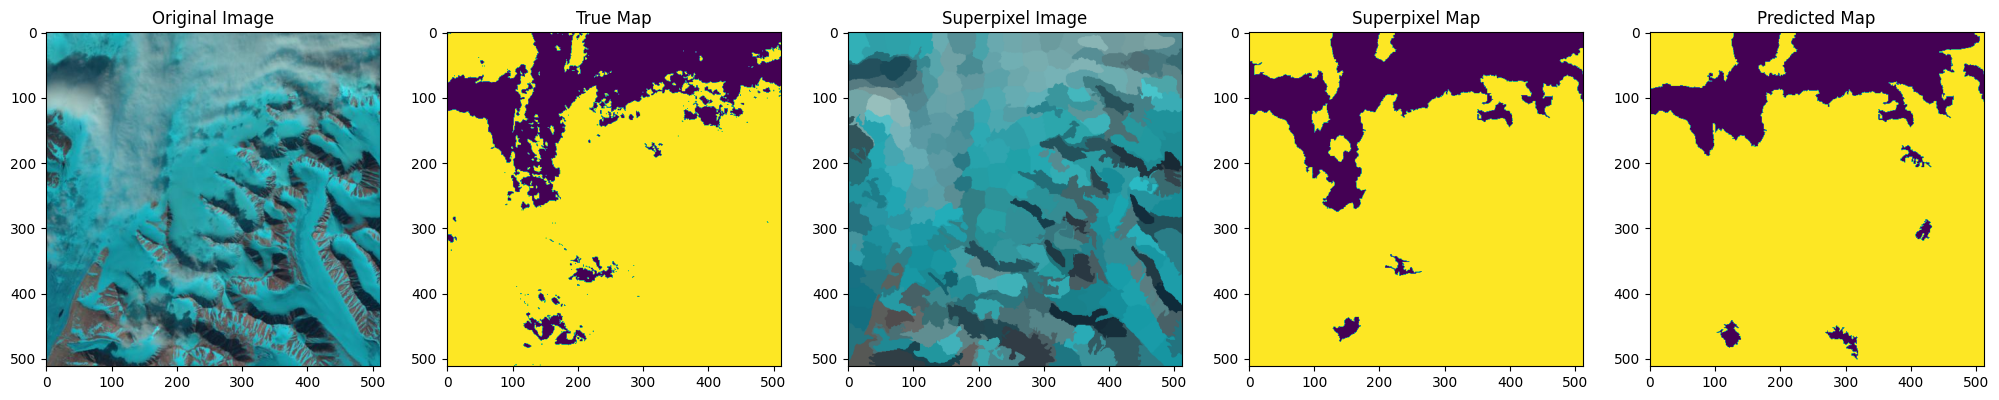

In [83]:
##plot segmented_image_rgb
i = 244

y_true = data_utils.unpad_and_map(X[i],y[i],original_ordering[i],slic_map[i])
y_pred = np.round(segmentationModel(torch.tensor([X[i].T], dtype=torch.float32)).detach().numpy().reshape(-1))
y_pred = data_utils.unpad_and_map(X[i],y_pred,original_ordering[i],slic_map[i])
## Make a 1x3 subplot
fig, ax = plt.subplots(1, 5, figsize=(25, 10))

## Plot the original image
ax[0].imshow(patches[i])
ax[0].set_title('Original Image')

## Plot the true segmentation
ax[1].imshow(mask[i])
ax[1].set_title('True Map')

## Plot the superpixel segmentation
ax[2].imshow(raw[i])
ax[2].set_title('Superpixel Image')

## Plot the true segmentation
ax[3].imshow(y_true)
ax[3].set_title('Superpixel Map')

## Plot the predicted segmentation
ax[4].imshow(y_pred)
ax[4].set_title('Predicted Map')

## Show the plot
plt.show()

### Calculate DICE and Jaccaard Index

In [65]:
## Write a function to calculate the dice score between two images
def get_jaccard_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    jaccard = np.sum(intersection) / np.sum(union)
    return jaccard

def get_dice_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    dice = 2 * np.sum(intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice

### SLIC

In [76]:
pred_maps = []
true_maps = []
for i in tqdm(test_index):
    y_pred = np.round(segmentationModel(torch.tensor([X[i].T], dtype=torch.float32)).detach().numpy().reshape(-1))
    pred = data_utils.unpad_and_map(X[i],y_pred,original_ordering[i],slic_map[i])
    pred_maps.append(pred)

    true = data_utils.unpad_and_map(X[i],y[i],original_ordering[i],slic_map[i])
    true_maps.append(true)

dice = []
for i,j in tqdm(zip(np.array(pred_maps),np.array(true_maps))):
    dice.append(get_dice_score(i,j))

jaccard = []
for i,j in tqdm(zip(np.array(pred_maps),np.array(true_maps))):
    jaccard.append(get_jaccard_score(i,j))

  0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [78]:
print("SLIC Dice:", np.mean(dice))
print("SLIC Jaccard:", np.mean(jaccard))

SLIC Dice: 0.8765876775294492
SLIC Jaccard: 0.8202331560274645


### Overall

In [79]:
pred_maps = []
for i in tqdm(test_index):
    y_pred = np.round(segmentationModel(torch.tensor([X[i].T], dtype=torch.float32)).detach().numpy().reshape(-1))
    pred = data_utils.unpad_and_map(X[i],y_pred,original_ordering[i],slic_map[i])
    pred_maps.append(pred)

dice = []
for i,j in tqdm(zip(np.array(pred_maps),mask[test_index])):
    dice.append(get_dice_score(i,j))

jaccard = []
for i,j in tqdm(zip(np.array(pred_maps),mask[test_index])):
    jaccard.append(get_jaccard_score(i,j))

  0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [81]:
print("Overall Dice:", np.mean(dice))
print("Overall Jaccard:", np.mean(jaccard))

Overall Dice: 0.8465991782719587
Overall Jaccard: 0.7749840921688778
